# Tutorial: Using DFtoVW and exploring VW output

---

The purpose of this tutorial is to show how to use the `DFtoVW` class to convert a pandas's DataFrame into a list of Vowpal Wabbit examples and to explore the outputs (model weights, VW output log) of the trained model. The VW output log is parsed using the class `VWLogParser` defined in this notebook.

The task is to predict the concentration of [particulate matter](https://en.wikipedia.org/wiki/Particulates) (more specifically PM 2.5) in the atmosphere of 5 chinese cities. The original dataset contains 19 columns (targets, datetime and atmospheric features) and 167 358 observations.
- For more details on the data, see the following UCI repository: https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities
- For the associated academic papers, see [Liang, Xuan, et al. "PM2. 5 data reliability, consistency, and air quality assessment in five Chinese cities."](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JD024877) and [Liang, Xuan, et al. "Assessing Beijing's PM2. 5 pollution: severity, weather impact, APEC and winter heating."](https://royalsocietypublishing.org/doi/10.1098/rspa.2015.0257)

The data can be download from the following URL: https://archive.ics.uci.edu/ml/machine-learning-databases/00394/FiveCitiePMData.rar. A function `download_data` is available in this notebook to download and extract the data (but this step can also be done manually). The folder containing the data is defined using the constant variable `DATA_FOLDER` and is `'PM_DATA'` by default.

### Notebook outline

**1. Data**

**2. Train a first model**

**3. Visualizing model outputs**

**4. Train a more complex model**


### Requirements

The notebook was developed for VW 8.11.0.

It should work with older versions (>= 8.10) except for one cell in section 4.3 where the attribute `name` of `Feature` is accessed.

---


### Importing packages

In [39]:
import os
from os.path import join
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from vowpalwabbit.DFtoVW import DFtoVW
from vowpalwabbit.pyvw import vw

### Function and class definition

In [40]:
# VW output parsing function/class
class VWLogParser:
    """Parser for Vowpal Wabbit output log"""
    
    def __init__(self, file_path_or_list):
        """The file name or list of lines to parse"""
        if isinstance(file_path_or_list, (list, str)):
            self.file_path_or_list = file_path_or_list
        else:
            raise TypeError("Argument `fname` should be a str (for file path) or a list of log lines")
    
    def parse(self):
        """Parse the output from `vw` command, return dataframe/dictionnaries with the associated data."""
        # Init containers 
        self.table_lst = []
        self.params = {}
        self.metrics = {}

        self.inside_table = False
        self.after_table = False
        
        if isinstance(self.file_path_or_list, list):
            for row in self.file_path_or_list:
                self._parse_vw_row(row)
        else:
            with open(self.file_path_or_list, "r") as f:
                for row in f:
                    self._parse_vw_row(row)
            

        self.df = self._make_output_df(self.table_lst)

        return self.params, self.df, self.metrics

    def _cast_string(self, s):
        """Cast to float or int if possible"""
        try:
            out = float(s)
        except ValueError:
            out = s
        else:
            if out.is_integer():
                out = int(out)

        return out

    def _make_output_df(self, lst):
        """Make dataframe from the list"""
        # Make columns from first and second elements of the list
        columns = [f"{first_row}_{second_row}" for (first_row, second_row) in zip(*lst[:2])]

        df = pd.DataFrame(data=lst[2:], columns=columns)

        # Cast cols to appropriate types
        int_cols = ["example_counter", "current_features"]
        for col in int_cols:
            df[col] = df[col].astype(int)

        float_cols = df.columns.drop(int_cols)
        for col in float_cols:
            df[col] = df[col].astype(float)

        return df

    def _parse_vw_row(self, row):
        """Parse row and add parsed elements to instance attributes params, metrics and table_lst"""
        if "=" in row:
            param_name, value = [element.strip() for element in row.split("=", maxsplit=1)]
            if self.after_table:
                self.metrics[param_name] = self._cast_string(value)
            else:
                self.params[param_name] = self._cast_string(value)
        elif ":" in row:
            param_name, value = [element.strip() for element in row.split(":", maxsplit=1)]
            self.params[param_name] = self._cast_string(value)

        elif not self.after_table:
            if re.match("average\s+since", row):
                self.inside_table = True
            if row == "\n":
                self.inside_table = False
                self.after_table = True
            if self.inside_table:
                self.table_lst += [row.split()]


# Data import/download functions
def download_data(dest_dir="PM_DATA"):
    import requests
    from io import BytesIO
    from rarfile import RarFile
    
    URL_PM_CITIES = "https://archive.ics.uci.edu/ml/machine-learning-databases/00394/FiveCitiePMData.rar"

    print(f"Downloading data at {URL_PM_CITIES}")
    r = requests.get(URL_PM_CITIES)
    bcontent = BytesIO(r.content)
    rf = RarFile(bcontent)
    
    print(f"Extracting content in folder {repr(dest_dir)}")
    rf.extractall(dest_dir)


def import_data(folder_path, verbose=True):
    df_lst = []
    for fname in os.listdir(folder_path):
        fpath = join(folder_path, fname)
        if verbose:
            print(f"Importing file: {fpath}")
        city_name = re.sub("pm$", repl="", string=re.search("^[a-z]+", string=fname.lower()).group())
        
        df_city = pd.read_csv(fpath)
        df_city_clean = (df_city
                         .assign(city=city_name)
                         .drop(columns=["No"] + [col for col in df_city.columns if ("PM" in col) and (col != "PM_US Post")])
                         .rename(columns={"PM_US Post": "PM"})
                         .dropna(subset=["PM"])
        )
        df_lst += [df_city_clean]
    
    df_city = (
        pd.concat(df_lst) # append dataframes
        .sample(frac=1, random_state=123) # shuffle
        .reset_index(drop=True)
    )
    
    return df_city


# Model weight inspection functions                
def get_feature_names(df):
    cat_names = get_cat_feature_names(df)
    num_names = df.select_dtypes(np.number).columns.tolist()
    
    return cat_names + num_names


def get_cat_feature_names(df):
    unique_values_cat = df.select_dtypes(object).apply(lambda s: s.dropna().unique())
    cat_names = [f"{key}={value}" 
                 for (key, unique_values) in unique_values_cat.items()
                 for value in unique_values
    ]
    
    return cat_names


def get_weight_from_name(model, feature_name, namespace_name=" "):
    space_hash = model.hash_space(namespace_name)
    feat_hash = model.hash_feature(feature_name, space_hash)
    return model.get_weight(feat_hash)


### Constants

In [41]:
# Data
DATA_FOLDER = "PM_DATA"

# Graphical
SUPTITLE_FONTSIZE = 20
SUPTITLE_FONTWEIGHT = "bold"
TITLE_FONTSIZE = 15

---

# 1. Data

## 1.1. Import

In [42]:
if not (os.path.isdir(DATA_FOLDER) and len(os.listdir(DATA_FOLDER)) == 5):
    download_data(DATA_FOLDER)

df = import_data(DATA_FOLDER)

df.head()

Importing file: PM_DATA/ShanghaiPM20100101_20151231.csv
Importing file: PM_DATA/ShenyangPM20100101_20151231.csv
Importing file: PM_DATA/ChengduPM20100101_20151231.csv
Importing file: PM_DATA/GuangzhouPM20100101_20151231.csv
Importing file: PM_DATA/BeijingPM20100101_20151231.csv


,year,month,day,hour,season,PM,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,city
0,2011,9,27,2,3.0,226.0,13.0,87.00,1017.0,15.000000,SE,41.13,0.0,0.000000,beijing
1,2013,6,26,2,2.0,51.0,17.0,82.89,1000.0,20.000000,SE,1.00,8.8,10.900000,shenyang
2,2013,11,16,19,3.0,102.0,5.0,48.03,1019.0,16.000000,SW,3.00,0.0,0.000000,shanghai
3,2015,5,20,16,1.0,13.0,0.0,14.00,1012.0,30.000000,NW,4.92,0.0,0.000000,beijing
4,2015,5,9,15,1.0,7.0,22.1,91.00,1000.0,23.700001,SE,1.70,1.5,35.700001,guangzhou


The full label of some features (the non obvious ones):

- PM: PM2.5 concentration (ug/m^3)
- DEWP: Dew Point (Celsius Degree)
- TEMP: Temperature (Celsius Degree)
- HUMI: Humidity (%)
- PRES: Pressure (hPa)
- cbwd: Combined wind direction
- Iws: Cumulated wind speed (m/s)
- precipitation: hourly precipitation (mm)
- Iprec: Cumulated precipitation (mm)

## 1.2. Types

The types of the columns:

In [44]:
df.dtypes

year               int64
month              int64
day                int64
hour               int64
season           float64
PM               float64
DEWP             float64
HUMI             float64
PRES             float64
TEMP             float64
cbwd              object
Iws              float64
precipitation    float64
Iprec            float64
city              object
dtype: object

Some columns (`year`, `month`, `day`, `hour`, `season`) have been imported as integer/float type but **should be treated as categorical** by the model. Hence, we convert these columns to categorical (`str`) type.

In [45]:
to_cat_cols = ["year", "month", "day", "hour", "season"]

for col in to_cat_cols:
    df[col] = df[col].astype(str)

# Pandas converts np.nan to "nan" when casting to object/str :-(
df[df == "nan"] = np.nan

Also, we standardize the numerical variables so we can compare their relative importance.

In [46]:
for col in df.select_dtypes(np.number).columns.difference(["PM", "log_PM"]):
    df[col] = (df[col] - df[col].mean()) / df[col].std()

## 1.3. Highly correlated features

The most correlated (> 0.95) variable(s):

In [48]:
(df.corr()
 .reset_index()
 .melt(id_vars="index", value_name="corr")
 .loc[lambda df: df["index"] < df["variable"]] # to get lower triangular part of the matrix
 .loc[lambda df: df["corr"] > 0.95]
)

,index,variable,corr
55,Iprec,precipitation,0.999998


We drop the `Iprec` variable since it is almost perfectly correlated with the `precipitation` variable.

In [49]:
df.drop(columns=["Iprec"], inplace=True)

# 2. Train a first model

## 2.1. Converting pandas's DataFrame to Vowpal Wabbit input format.

We now use `DFtoVW` class to convert this dataframe to VW input format. 

There are 2 ways to use the class `DFtoVW`:
- **Basic usage**, using the `DFtoVW.from_colnames` convenience method.
- **Advanced usage**, that relies on the VW input format specification (see: https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Input-format). It is build upon classes such as `Feature`, `Namespace` or `SimpleLabel`, `MulticlassLabel` etc..

The current section illustrates the basic usage. Section 4 will present the advanced usage.


To instantiate a `DFtoVW` object, the `DFtoVW.from_colnames` method is used: the user provides the target name as a string (`y`), the feature names as a list of string (`x`) and the dataframe (`df`) to be converted. The user can also specify the type of label (argument `label_type`, default being `simple_label` for the regression).

To perform the conversion, one must call the `convert_df` method. The examples will be return as a list of strings.

In [10]:
y = "PM"
x = ['year', 'month', 'day', 'hour', 'season', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'city']

print("label:", y)
print("features:", x)

converter = DFtoVW.from_colnames(df=df, y=y, x=x)
examples = converter.convert_df()

label: PM
features: ['year', 'month', 'day', 'hour', 'season', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'city']


We can inspect the first few examples:

In [11]:
examples[:5]

['226.0 | year=2011 month=9 day=27 hour=2 season=3.0 DEWP:0.08959465332461863 HUMI:0.3882591675380959 PRES:0.33023244897304604 TEMP:-0.09454293289813515 cbwd=SE Iws:0.3992336466478102 precipitation:-0.0025309449430064965 city=beijing',
 '51.0 | year=2013 month=6 day=26 hour=2 season=2.0 DEWP:0.16859123637869186 HUMI:0.3127123038886084 PRES:-1.3551226813011634 TEMP:0.3627977627323019 cbwd=SE Iws:-0.4485512843970286 precipitation:0.001016342077488344 city=shenyang',
 '102.0 | year=2013 month=11 day=16 hour=19 season=3.0 DEWP:-0.06839851278352785 HUMI:-0.32805744472967246 PRES:0.5285095231229531 TEMP:-0.003074793772047733 cbwd=SW Iws:-0.4062993566100942 precipitation:-0.0025309449430064965 city=shanghai',
 '13.0 | year=2015 month=5 day=20 hour=16 season=1.0 DEWP:-0.1671442416011194 HUMI:-0.9535707707618039 PRES:-0.16546023640172142 TEMP:1.277479153993176 cbwd=NW Iws:-0.36573750593463716 precipitation:-0.0025309449430064965 city=beijing',
 '7.0 | year=2015 month=5 day=9 hour=15 season=1.0 

For categorical features, that VW format is `feature_name=feature_value` whereas for numerical features the format is `feature_name:feature_value`. One nice property of the class is that it will build the appropriate VW type (numerical or categorical) based on the pandas's column type.

Also note that:
- for categorical variables, VW adds `:1` behind the scene. For instance `day=14` is equivalent to `day=14:1`
- The `=` doesn't have any special meaning and another symbol could have been used. However it's quite standard to use `=`

Finally, if the feature name provided by the user is not found of the dataframe, the class will raise a `ValueError`:

In [12]:
try:
    DFtoVW.from_colnames(df=df, y=y, x=["TEMP", "COLUMN_NOT_IN_DF"])
except Exception as e:
    print(type(e))
    print(e)

<class 'ValueError'>
In 'Feature': column(s) 'COLUMN_NOT_IN_DF' not found in dataframe.


## 2.2. Define and train model

We now define the VW model. Note that we enable logging and also set the progress parameter (`P`) to 1 to log the information _for each iteration_.

In [13]:
model = vw(P=1, enable_logging=True)

for ex in examples:
    model.learn(ex)

model.finish()

# 3. Visualizing model's outputs

## 3.1. Retrieving model's parameters, losses/predictions and summary metrics from the log

Since we enable logging in the model definition (subsection 2.2), we can get the model's log. The log is returned as a list of strings by the `vw.get_log` method. Below is the first 20 lines:

In [14]:
model.get_log()[:20]

['Num weight bits = 18\n',
 'learning rate = 0.5\n',
 'initial_t = 0\n',
 'power_t = 0.5\n',
 'using no cache\n',
 'Reading datafile = \n',
 'num sources = 1\n',
 'Enabled reductions: gd, scorer\n',
 'average  since         example        example  current  current  current\n',
 'loss     last          counter         weight    label  predict features\n',
 '10145.675351 10145.675351          100          100.0  26.0000   5.8897       13\n',
 '9643.625754 9141.576157          200          200.0  23.0000  10.0958       14\n',
 '8446.637077 6052.659724          300          300.0  18.0000  16.1903       14\n',
 '8587.875110 9011.589207          400          400.0  50.0000  16.4756       14\n',
 '8577.194673 8534.472927          500          500.0   9.0000  17.8868       14\n',
 '8548.963446 8407.807308          600          600.0  69.0000  20.3958       14\n',
 '8098.884780 5398.412787          700          700.0  84.0000  20.4876       14\n',
 '7831.005161 5955.847824          800        

The class `VWLogParser` can be used to parse this log. It will return the following objects:
- the parameters (in the first lines)
- the information available at each iteration (since `P=1`)
- the summary metrics at the end of the log

The parsed information is available as `dict` and `DataFrame` objects that can be easily manipulated.

In [15]:
log_parser = VWLogParser(model.get_log())
params, df_iter, summary_metrics = log_parser.parse()

In [16]:
print("Model's parameters")
display(params)
print("\n")

print("Information at each iteration")
display(df_iter)
print("\n")

print("Summary metrics")
display(summary_metrics)

Model's parameters


{'Num weight bits': 18,
 'learning rate': 0.5,
 'initial_t': 0,
 'power_t': 0.5,
 'Reading datafile': '',
 'num sources': 1,
 'Enabled reductions': 'gd, scorer'}



Information at each iteration


,average_loss,since_last,example_counter,example_weight,current_label,current_predict,current_features
0,10145.675351,10145.675351,100,100.0,26.0,5.8897,13
1,9643.625754,9141.576157,200,200.0,23.0,10.0958,14
2,8446.637077,6052.659724,300,300.0,18.0,16.1903,14
3,8587.875110,9011.589207,400,400.0,50.0,16.4756,14
4,8577.194673,8534.472927,500,500.0,9.0,17.8868,14
...,...,...,...,...,...,...,...
1668,4166.458677,5715.945020,166900,166900.0,53.0,70.3438,14
1669,4166.298048,3898.207988,167000,167000.0,45.0,41.3309,14
1670,4166.330769,4220.974796,167100,167100.0,151.0,104.5944,14
1671,4165.831614,3331.743557,167200,167200.0,19.0,45.8334,13




Summary metrics


{'number of examples': 167358,
 'weighted example sum': 167358,
 'weighted label sum': 12331595,
 'average loss': 4165.371186,
 'best constant': 73.683929,
 'total feature number': 2336281}

## 3.2. Visualizing losses across iterations + distribution of selected metrics

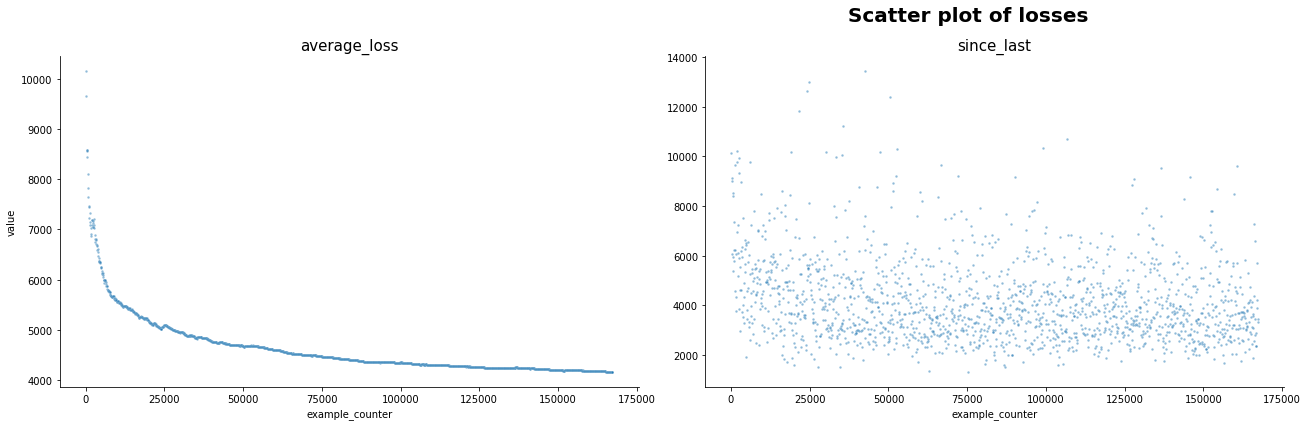

In [17]:
scatter_var = ["average_loss", "since_last"]
g = sns.relplot(data=df_iter[scatter_var + ["example_counter"]].melt(id_vars="example_counter"), 
                x="example_counter", y="value", col="variable",
                col_wrap=3, facet_kws={'sharey': False, 'sharex': True}, 
                kind="scatter", s=6, height=6, aspect=1.5, alpha=.5)
g.fig.suptitle('Scatter plot of losses', fontsize=SUPTITLE_FONTSIZE, fontweight=SUPTITLE_FONTWEIGHT)
g.set_titles("{col_name}", size=TITLE_FONTSIZE)
g.fig.tight_layout()

In what follows, we consider the metrics for iterations after 50 000.

In [18]:
start_idx = 50_0

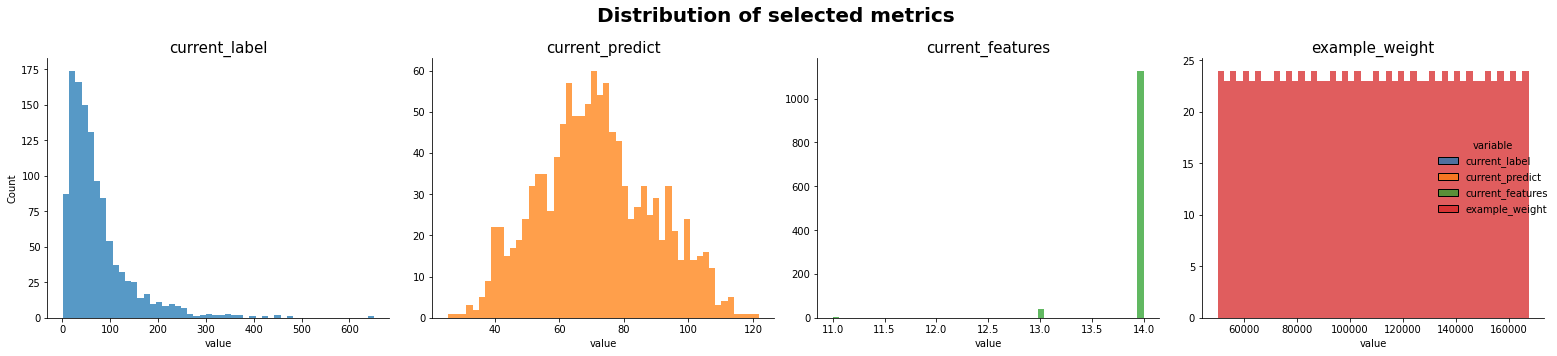

In [35]:
distr_vars = ["current_label", "current_predict", "current_features", "example_weight"]

g = sns.displot(data=df_iter.loc[start_idx:, distr_vars].melt(), 
                x="value", col="variable", multiple="dodge", hue="variable", bins=50,
                common_bins=False, facet_kws=dict(sharex=False, sharey=False), col_wrap=4, height=5)
g.fig.suptitle('Distribution of selected metrics', fontsize=SUPTITLE_FONTSIZE, fontweight=SUPTITLE_FONTWEIGHT)
g.set_titles("{col_name}", size=TITLE_FONTSIZE)
g.fig.tight_layout()

We notice that the distribution of the predictions differs substantially from the one of the labels. 

## 3.3. Visualizing the predictions of the model

This section offers a visualization of the model's predictions and compares them with the labels (the truth). 

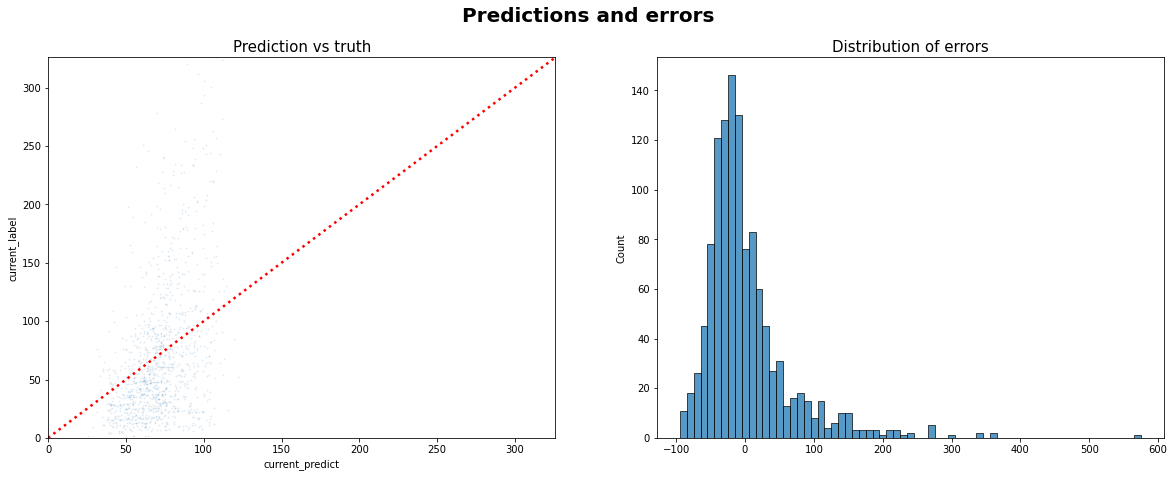

In [36]:
error = df_iter.current_label - df_iter.current_predict

f, (ax1, ax2) = plt.subplots(figsize=(20, 7), ncols=2)
f.suptitle('Predictions and errors', fontsize=SUPTITLE_FONTSIZE, fontweight=SUPTITLE_FONTWEIGHT)

# Scatterplot pred vs truth
sns.scatterplot(data=df_iter.loc[start_idx:], x="current_predict", y="current_label", ax=ax1, s=3, alpha=.15)
ax1.set_title("Prediction vs truth", fontsize=TITLE_FONTSIZE)
max_range = int(df_iter[["current_label", "current_predict"]].quantile(.99).max())
ax1.set_xlim([0, max_range])
ax1.set_ylim([0, max_range])

# Adding x=y line
#range_x = range(0, int(df_iter[["current_predict", "current_label"]].max().min()))
range_x = range(0, max_range)
ax1.plot(range_x, range_x, linestyle=":", color="red", linewidth=2.5)

# Histogram of errors
sns.histplot(error[start_idx:], ax=ax2)
ax2.set_title("Distribution of errors", fontsize=TITLE_FONTSIZE)

plt.show()


The model tends to undervalue the concentration of PM. Another way to see it is that the errors (difference between the label and the prediction) doesn't seem normally distributed (especially the right tail).

## 3.4. Visualizing learnt weights

In [37]:
# Get VW feature names
feature_names = get_feature_names(df)

# Get weights from feature names
weights_df = pd.DataFrame([(name, get_weight_from_name(model, name), "=" in name) for name in feature_names], 
                          columns=["vw_feature_name", "weight", "is_cat"])

# Adding columns for easier visualization
weights_df["feature_name"] = weights_df.apply(lambda row: row.vw_feature_name.split("=")[0] if row.is_cat else row.vw_feature_name, axis=1)
weights_df["feature_value"] = weights_df.apply(lambda row: row.vw_feature_name.split("=")[1].zfill(2) if row.is_cat else row.vw_feature_name, axis=1)
weights_df.sort_values(["feature_name", "feature_value"], inplace=True)

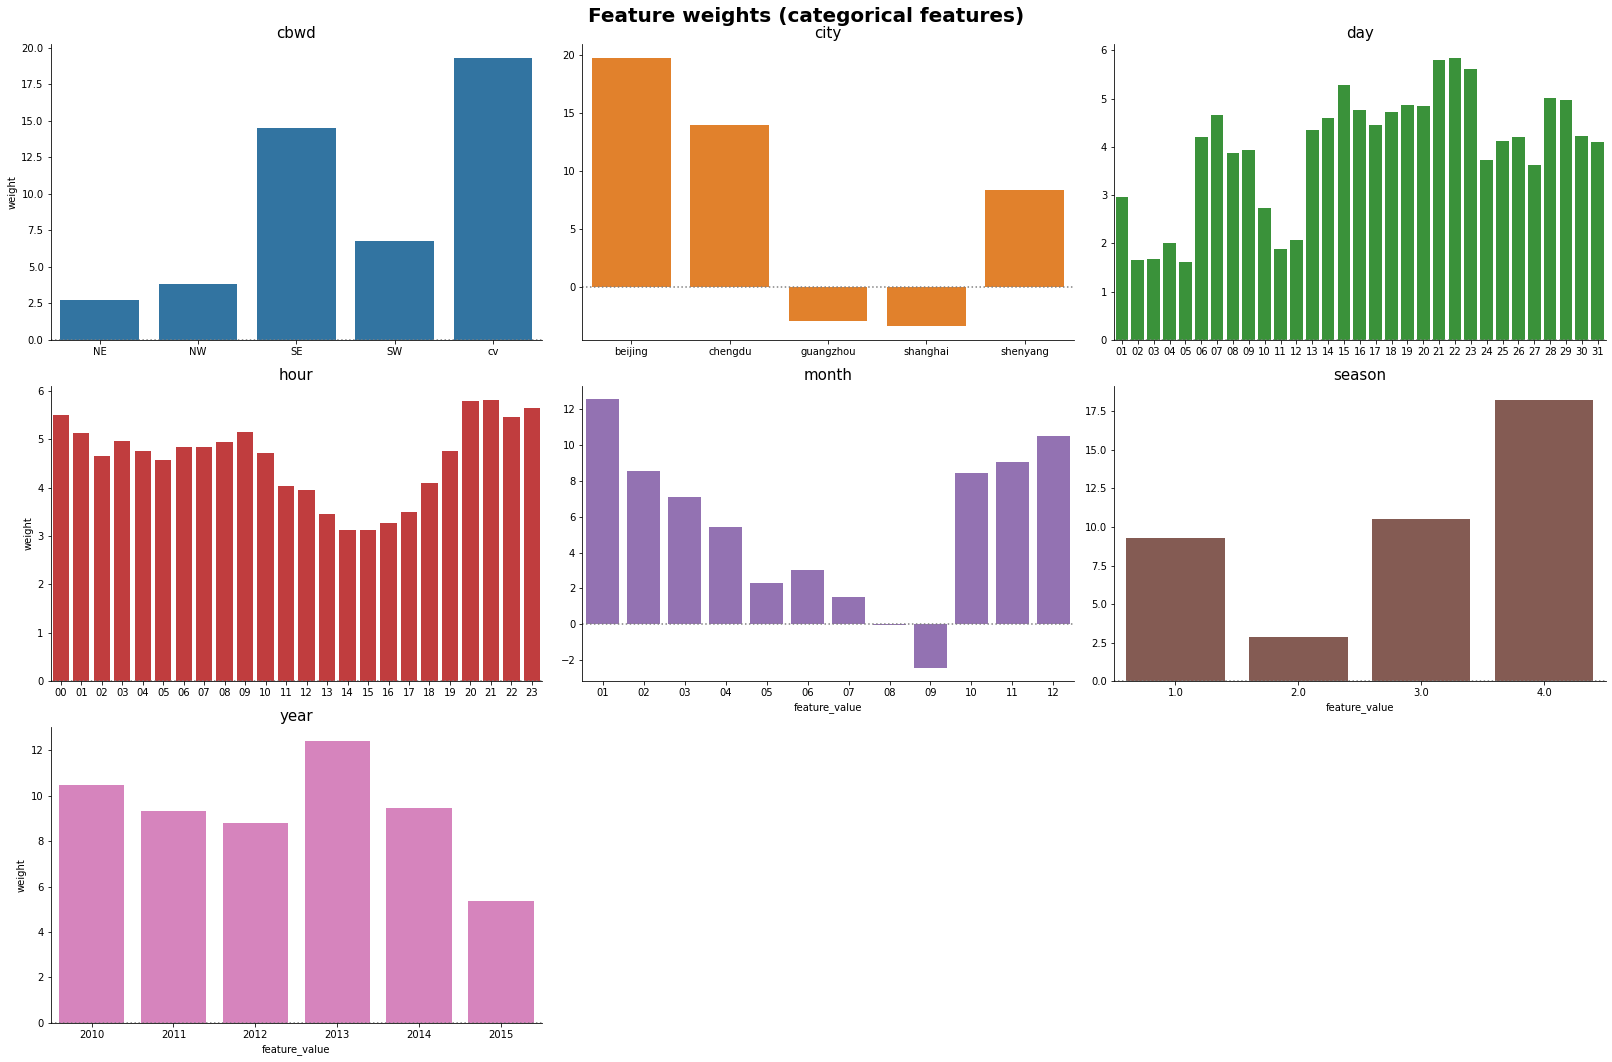

In [38]:
g = sns.catplot(data=weights_df[lambda df: df.is_cat], kind="bar", x="feature_value", y="weight", col="feature_name", hue="feature_name",
                col_wrap=3, sharex=False, sharey=False, aspect=1.5, dodge=False)
g.fig.suptitle('Feature weights (categorical features)', fontsize=SUPTITLE_FONTSIZE, fontweight=SUPTITLE_FONTWEIGHT)
g.set_titles("{col_name}", size=TITLE_FONTSIZE)

# Add horizontal bar at y=0
for ax in g.axes.flat:
    ax.axhline(0, color="gray", linestyle=":")
g.fig.tight_layout()

Based on the weights learnt by the model, the predicted value for pollution will be higher:

- for wind orientation "calm and variable" (CV)
- for cities such as Beijing or Chengdu
- for winter season/months
- for certain day of month such as 21-23 (oddly)

The predicted value will to be lower: 

- for wind from the north
- for year 2015
- for hours around noon
- for certain cities such as Guangzhou and Shanghai.

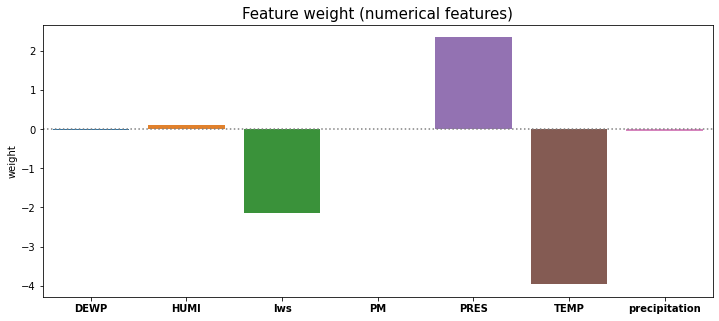

In [23]:
f, ax = plt.subplots(figsize=(12, 5))
ax = sns.barplot(data=weights_df[lambda df: df.is_cat == False], x="feature_name", y="weight")
ax.set_title("Feature weight (numerical features)", fontsize=TITLE_FONTSIZE)

# Set xlabels in bold, remove x-axis title
ax.set_xticklabels(ax.get_xticklabels(), fontweight=SUPTITLE_FONTWEIGHT)
ax.set(xlabel=None)

# Add horizontal line
ax.axhline(0, linestyle=":", color="gray")

plt.show()

Higher cumulated wind speed (Iws) and higher temperature (TEMP) are associated with lower predicted values. 

Higher air pressure (PRES) is associated with higher predicted values.

# 4. Train a more complex model: using log transformed target and namespace interactions

This section illustrates the **advanced usage** of `DFtoVW` class. To do so, we will need to import some specific classes/types from the `DFtoVW` module.

In [24]:
from vowpalwabbit.DFtoVW import SimpleLabel, Namespace, Feature

The following drawing explains **how to use these classes**:

<div>
<img src="DFtoVW_usage.png" align="center" width="1250"/>
</div>

## 4.1. Applying logarithm transformation to the target

The distribution of the target is close to a log-normal distribution:

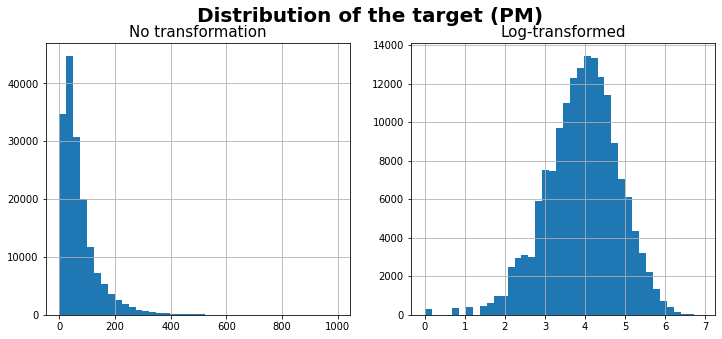

In [25]:
f, (ax1, ax2) = plt.subplots(figsize=(12, 5), ncols=2)
f.suptitle('Distribution of the target (PM)', fontsize=SUPTITLE_FONTSIZE, fontweight=SUPTITLE_FONTWEIGHT)

df["PM"].hist(bins=40, ax=ax1)
ax1.set_title("No transformation", fontsize=TITLE_FONTSIZE)

np.log(df["PM"]).hist(bins=40, ax=ax2)
ax2.set_title("Log-transformed", fontsize=TITLE_FONTSIZE)

plt.show()

We decide to train the model on the log transformed version of the target (called `log_PM`). 

For a regression task, we use the `SimpleLabel` class (more details on this type in the [Input Format page](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Input-format#simple) of the wiki) to represent the target.

In [26]:
df["log_PM"] = df["PM"].apply(np.log)
label = SimpleLabel("log_PM")

## 4.2. Defining namespaces

Namespaces are defined using the `Namespace` class. They are formed of a (list of) `Feature` and can have a name.

In [27]:
# Datetime namespace
datetime_features = ["year", "month", "day", "hour", "season"]
ns_datetime = Namespace(features=[Feature(col) for col in datetime_features], name="datetime_ns")

# City namespace
ns_city = Namespace(features=Feature("city"), name="city_ns")

# Weather namespace
weather_features = ['DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation']
ns_weather = Namespace(features=[Feature(col) for col in weather_features], name="weather_ns")

## 4.3. Converting to VW format and training model

In [28]:
converter_advanced = DFtoVW(df=df, namespaces=[ns_datetime, ns_weather, ns_city], label=label)

`Namespace` and `Feature` objects can be accessed using `DFtoVW`'s instance attributes `namespaces` and `features`:

In [29]:
for namespace in converter_advanced.namespaces:
    print("namespace:", namespace.name)
    for feature in namespace.features:
        print("\tfeature:", feature.name)

namespace: datetime_ns
	feature: year
	feature: month
	feature: day
	feature: hour
	feature: season
namespace: weather_ns
	feature: DEWP
	feature: HUMI
	feature: PRES
	feature: TEMP
	feature: cbwd
	feature: Iws
	feature: precipitation
namespace: city_ns
	feature: city


We can inspect the first few examples:

In [30]:
examples_advanced = converter_advanced.convert_df()
examples_advanced[:5]

['5.420534999272286 |datetime_ns year=2011 month=9 day=27 hour=2 season=3.0 |weather_ns DEWP:0.08959465332461863 HUMI:0.3882591675380959 PRES:0.33023244897304604 TEMP:-0.09454293289813515 cbwd=SE Iws:0.3992336466478102 precipitation:-0.0025309449430064965 |city_ns city=beijing',
 '3.9318256327243257 |datetime_ns year=2013 month=6 day=26 hour=2 season=2.0 |weather_ns DEWP:0.16859123637869186 HUMI:0.3127123038886084 PRES:-1.3551226813011634 TEMP:0.3627977627323019 cbwd=SE Iws:-0.4485512843970286 precipitation:0.001016342077488344 |city_ns city=shenyang',
 '4.624972813284271 |datetime_ns year=2013 month=11 day=16 hour=19 season=3.0 |weather_ns DEWP:-0.06839851278352785 HUMI:-0.32805744472967246 PRES:0.5285095231229531 TEMP:-0.003074793772047733 cbwd=SW Iws:-0.4062993566100942 precipitation:-0.0025309449430064965 |city_ns city=shanghai',
 '2.5649493574615367 |datetime_ns year=2015 month=5 day=20 hour=16 season=1.0 |weather_ns DEWP:-0.1671442416011194 HUMI:-0.9535707707618039 PRES:-0.165460

In this new model we will add interactions between the "weather" namespace and all the namespaces

In [31]:
model_advanced = vw(arg_str="--redefine W:=weather_ns --interactions W:", P=1, enable_logging=True)

for ex in examples_advanced:
    model_advanced.learn(ex)

model_advanced.finish()

## 4.4. Visualizing model output

We transform the labels and predictions using exponential function (since the target is log-transformed) so the can be compared with the ones of section 3.

In [32]:
params_advanced, df_iter_advanced, metrics_advanced = VWLogParser(model_advanced.get_log()).parse()

df_iter_advanced.current_label = np.exp(df_iter_advanced.current_label)
df_iter_advanced.current_predict = np.exp(df_iter_advanced.current_predict)

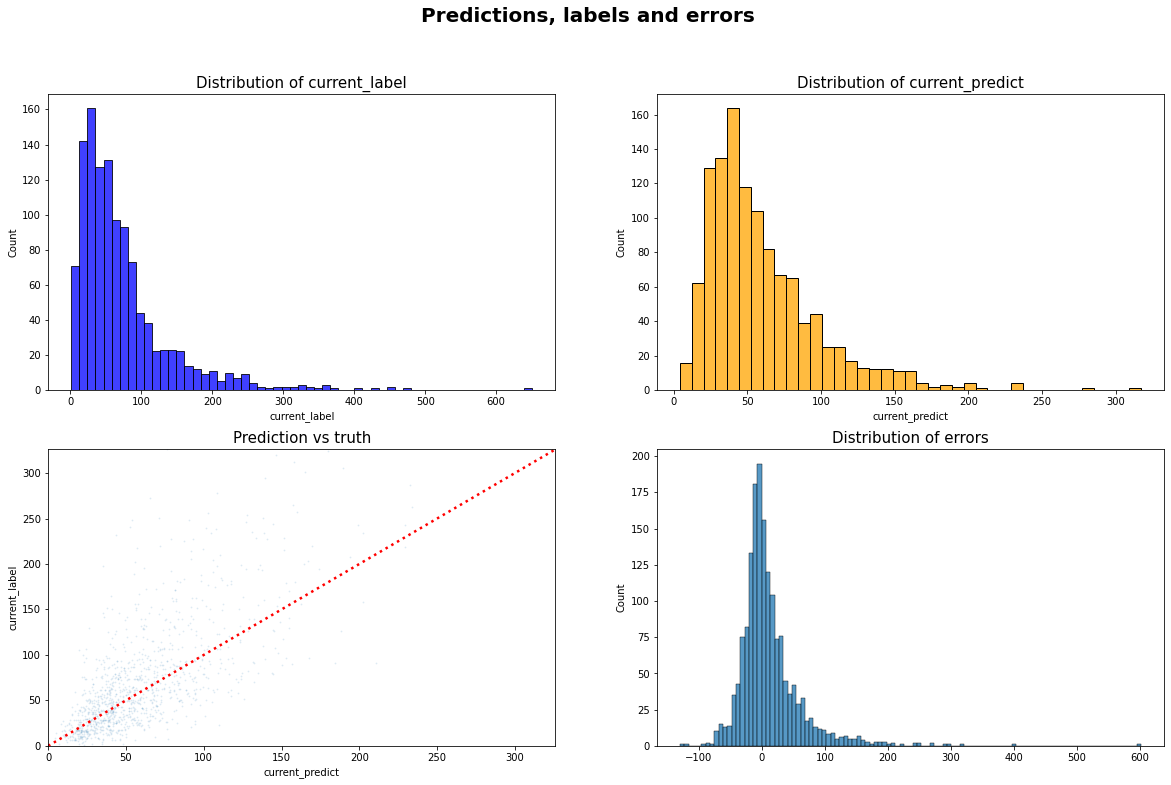

In [33]:
error_advanced = df_iter_advanced.current_label - df_iter_advanced.current_predict

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(20, 12), ncols=2, nrows=2)
f.suptitle('Predictions, labels and errors', fontsize=SUPTITLE_FONTSIZE, fontweight=SUPTITLE_FONTWEIGHT)

sns.histplot(df_iter_advanced.current_label.iloc[start_idx:], ax=ax1, color="blue")
ax1.set_title("Distribution of current_label", fontsize=TITLE_FONTSIZE)

sns.histplot(df_iter_advanced.current_predict.iloc[start_idx:], ax=ax2, color="orange")
ax2.set_title("Distribution of current_predict", fontsize=TITLE_FONTSIZE)

sns.scatterplot(data=df_iter_advanced.iloc[start_idx:], 
                x="current_predict", y="current_label", ax=ax3, s=3, alpha=.15)
ax3.set_title("Prediction vs truth", fontsize=TITLE_FONTSIZE)

# Add x=y line
max_range = int(df_iter[["current_label", "current_predict"]].quantile(.99).max())
ax3.set_xlim(0, max_range)
ax3.set_ylim(0, max_range)
range_x = range(0, max_range)
ax3.plot(range_x, range_x, linestyle=":", color="red", linewidth=2.5)

sns.histplot(error_advanced, ax=ax4)
ax4.set_title("Distribution of errors", fontsize=TITLE_FONTSIZE)

plt.show()

In this new model, the distribution of the predictions is more in line with the distribution of the labels.

The errors of this model are also closer to a normal distribution, even though the model still undervalues some observations.

## 4.5. Comparing models' performance

The model in section 2 is called "simple" and the current model (with interactions and log-transformed target) is called "advanced".

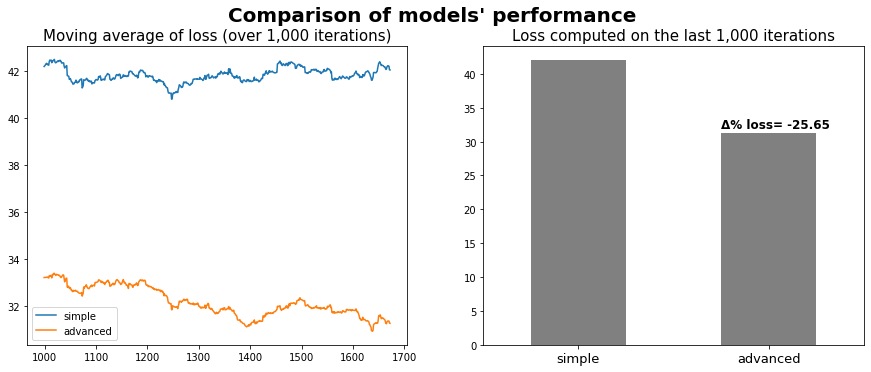

In [34]:
loss_type = 1 # 1 for L1-loss, 2 for L2-loss
n_iter = 10_000 # Number of iterations on which to compute the loss (for moving average and final value)

df_loss = (pd.concat([error, error_advanced], axis=1, keys=["simple", "advanced"])
           .apply(lambda x: np.power(np.abs(x), loss_type)))

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5.5))
f.suptitle("Comparison of models' performance", fontweight=SUPTITLE_FONTWEIGHT, fontsize=SUPTITLE_FONTSIZE)

df_loss.rolling(n_iter).mean().plot(ax=ax1)
ax1.set_title(f"Moving average of loss (over {n_iter:,} iterations)", fontsize=15)

loss_last_it = df_loss.tail(n_iter).mean()
pct_diff_loss = 100 * (loss_last_it.advanced / loss_last_it.simple - 1)

loss_last_it.plot.bar(ax=ax2, color="gray")
ax2.set_title(f"Loss computed on the last {n_iter:,} iterations", fontsize=15)
ax2.text(.75, loss_last_it.advanced * 1.025, f"Δ% loss= {pct_diff_loss:.2f}", fontsize=12, fontweight=SUPTITLE_FONTWEIGHT)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=13, rotation=0)

plt.show()

The model with interactions and log-transformed target offers substantial improvements over the simple model: the **loss** (computed on the last 10 000 observations) **decreases by about 23%**.